In [1]:
from MDP import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from math import floor

In [2]:
from matplotlib import animation, rc

dict_max = lambda x: max(v for v in x.values())
dict_mean = lambda x: sum(v for v in x.values())/len(x)
dict_min = lambda x: min(v for v in x.values())
dict_sum = lambda x: sum(v for v in x.values())

def generate_heatmap(grid, table, aggf=None, actions=False):
    if actions:
        hm = np.zeros((3,3))
        if aggf is None:
            aggf = lambda x: x

        hm[0,1] = table['up']
        hm[1,2] = table['right']
        hm[1,0] = table['left']
        hm[2,1] = table['down']

    else:
        hm = np.copy(grid) * 0
        if aggf is None:
            aggf = lambda x: x

        for k, v in table.items():
            hm[k] = aggf(v)

    return hm

def animate_values(data, fn=None):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(grid.shape[1], grid.shape[0]))

    for col in axs:
        col.set_axis_off()

    ims = []
    for i in range(len(data)):
        
        imQsa = axs[0].imshow(generate_heatmap(grid=grid, table=data[i]['Qsa'], aggf=fn), animated=True, origin='upper')
        imQa = axs[1].imshow(generate_heatmap(grid=grid, table=data[i]['Qa'], actions=True), animated=True, origin='upper')
        agent_marker = axs[0].text(data[i]['S'][1], data[i]['S'][0], 'X', ha="center", va="center", color="black", fontsize=20)
        ims.append([imQsa, imQa])
        agent_marker.remove()
        
    fig.colorbar(imQsa, ax=axs.ravel().tolist())
    
    ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True, repeat_delay=1000)
    plt.close()

    return ani

## Lambda Q simple extrinsic

In [3]:
max_steps = 1000
episode_timeout = 40
gamma = 0.8
alpha = 0.1
n_batches = 1

EXPLORATION_TYPE = 'LambQ_simple_extrinsic'
WORLD = 'G2'
batch_size = 1
FILE_SIG = f"Results_n={max_steps}, nB={batch_size}, exp={EXPLORATION_TYPE} WG, N_init_1"

if WORLD == 'WG':
    # Create the gridworld, and set cell values to equal rewards
    print('(Creating Willemsen Gridworld)')
    grid = np.ones((3, 9)) * -1
    grid[1,:8] = 0
    grid[1, 8] = 1
    grid[2, :8] = 0
    terminal_state = []
    for i in [0,2]:
        for j in range(8):
            terminal_state.append([i,j])
    terminal_state.append([1,8])
    terminal_state = np.array(terminal_state)
    initial_state = np.array([1, 0])
    blacked_state = np.array([[0, 8],[2, 8]])
elif WORLD == 'G2':
    # Gridworld 2
    grid = np.ones((10, 10)) * 0
    grid[3:7, 3:7] = -1
    grid[9,9] = 1
    terminal_state = np.array([[9,9]])
    initial_state = np.array([1, 0])
    blacked_state = np.array([[5,5], [4,5], [5,4], [4,4]])
    
env = Gridworld(grid, terminal_state, initial_state, blacked_state, episode_timeout)
env_greedy = Gridworld(grid, terminal_state, initial_state, blacked_state, episode_timeout)

In [4]:
M = []
for n in tqdm(range(n_batches)):
    agent = LambChop(estimators = [Estimator(approximator=bellman_Q_table(alpha=0.1, gamma=0.8), mask=identity()),
                                  Estimator(approximator=global_Q_abstractor(gamma=0.8),  mask=global_context())],
                    buffer = ReplayMemory(max_size=10000),
                    targets = [Target()],
                    counter = state_table(),
                    batch_size=batch_size)
    
    trajectories = []
    metrics = []
    epilen = []
    Gn = []
    step = 0
    while step < max_steps:
        # EXPLORE: by setting action selection to be explorative: "exploratory"
        agent.action_selection = "exploratory"
        action = agent.select_action(env.transition)
        transition = env.step(action)
        agent.observe(transition)
        Gn.append(transition.reward)
        agent.train()
        
        # EXPLOIT: by setting action selection to be exploitative: "greedy"
        agent.action_selection = "greedy"
        agent.epsilon = 0
        Gg = []
        
        # RUN entire trajectory, and set greedy env to the initial state
        env_greedy.reset()
        while not env_greedy.terminal and not env_greedy.timeout:
            action = agent.select_action(env_greedy.transition)
            transition = env_greedy.step(action)
            Gg.append(transition.reward)

        step += 1

        metrics.append({
            'Qsa': dict(agent.estimators[0].approximator.table), 
            'Qa': dict(agent.estimators[1].evaluate(0)),
            'S': transition.state_,
            'V': dict(agent.counter.table),
            'U': dict(agent.estimators[0].visits),
            'Gn': Gn,
            'Gg': Gg,
            'steps': step
            })
        
        if env.terminal or env.timeout:
            trajectories.append(agent.trajectory)
            epilen.append([len(agent.trajectory), len(Gg)])
            
            env.reset()
            agent.reset_trajectory()
            Gn = []
            
    M.append(metrics)

  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\CesareCarissimo\Documents\MARL\RapidRL\MDP\agent.py:103: RuntimeWarning: divide by zero encountered in true_divide
  Zigma = np.where(Sigma > 0, 1 / Sigma, 0.1)  # Zigma is the Inverse of the Sigma MSE matrix
C:\Users\CesareCarissimo\Documents\MARL\RapidRL\MDP\agent.py:119: RuntimeWarning: divide by zero encountered in log
  exp_bonus = np.where(n_s > 0, np.sqrt(np.log(t)/n_s), 1000)
C:\Users\CesareCarissimo\Documents\MARL\RapidRL\MDP\agent.py:119: RuntimeWarning: invalid value encountered in sqrt
  exp_bonus = np.where(n_s > 0, np.sqrt(np.log(t)/n_s), 1000)
C:\Users\CesareCarissimo\Documents\MARL\RapidRL\MDP\agent.py:119: RuntimeWarning: invalid value encountered in true_divide
  exp_bonus = np.where(n_s > 0, np.sqrt(np.log(t)/n_s), 1000)
C:\Users\CesareCarissimo\Documents\MARL\RapidRL\MDP\agent.py:119: RuntimeWarning: divide by zero encountered in true_divide
  exp_bonus = np.where(n_s > 0, np.sqrt(np.log(t)/n_s), 1000)


In [5]:
x = np.arange(0, M[0][-1]['steps'])
yn = []
yg = []
for i, metrics in enumerate(M[0]):
    Yn = 0
    Yg = 0
    for j, g in enumerate(metrics['Gn']):
        Yn += gamma**j*g
    for j, g in enumerate(metrics['Gg']):
        Yg += gamma**j*g
    
    yn.append(Yn)
    yg.append(Yg)

In [6]:
cumEpilen = np.cumsum([ele[0] for ele in epilen])
cumEpiG = np.cumsum([ele[1] for ele in epilen])

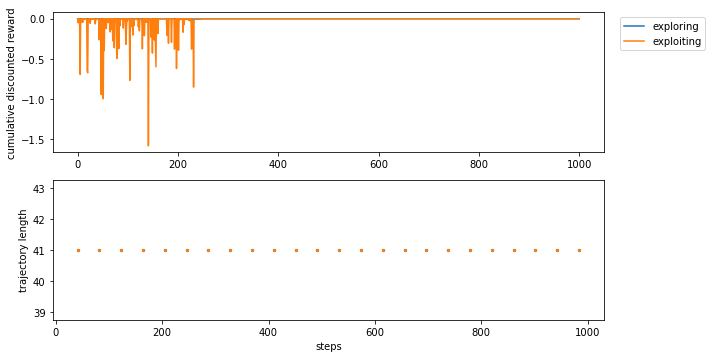

In [7]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,5))
ax1.plot(x, yn, label='exploring')

ax1.plot(x, yg, label='exploiting')

ax1.set_ylabel('cumulative discounted reward')
plt.xlabel('steps')

ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

ax2.set_ylabel('trajectory length')
ax2.scatter(cumEpilen, [ele[0] for ele in epilen], s=5)
ax2.scatter(cumEpiG, [ele[1] for ele in epilen], s=5)
plt.tight_layout()
plt.savefig('results/lambda_Q_extrinsic_learner_steps(%i).png' % (max_steps))

In [96]:
ani = animate_values(M[0], fn=dict_max)
estimator = ['Qsa', 'Qa']
Writer = animation.writers['ffmpeg']
writer = Writer(fps=3, metadata=dict(artist='Cesare Carissimo'), bitrate=1800)
ani.save(f"{FILE_SIG}-%s.mp4" % estimator, writer=writer)

## RMAX LambChop

In [20]:
max_steps = 1000
episode_timeout = 100
gamma = 0.8
alpha = 0.1
n_batches = 1

EXPLORATION_TYPE = 'LambQ_Rmax'
WORLD = 'G2'
batch_size = 1
FILE_SIG = f"Results_n={max_steps}, nB={batch_size}, exp={EXPLORATION_TYPE}, WORLD={WORLD}"

if WORLD == 'WG':
    # Create the gridworld, and set cell values to equal rewards
    print('(Creating Willemsen Gridworld)')
    grid = np.ones((3, 9)) * -1
    grid[1,:8] = 0
    grid[1, 8] = 1
    grid[2, :8] = 0
    terminal_state = []
    for i in [0,2]:
        for j in range(8):
            terminal_state.append([i,j])
    terminal_state.append([1,8])
    terminal_state = np.array(terminal_state)
    initial_state = np.array([1, 0])
    blacked_state = np.array([[0, 8],[2, 8]])
elif WORLD == 'G2':
    # Gridworld 2
    grid = np.ones((10, 10)) * 0
    grid[3:7, 3:7] = -1
    grid[9,9] = 1
    terminal_state = np.array([[9,9]])
    initial_state = np.array([1, 0])
    blacked_state = np.array([[5,5], [4,5], [5,4], [4,4]])
    
env = Gridworld(grid, terminal_state, initial_state, blacked_state, episode_timeout)
env_greedy = Gridworld(grid, terminal_state, initial_state, blacked_state, episode_timeout)

In [21]:
M = []
for n in range(n_batches):
    agent = LambChop(estimators = [Estimator(approximator=bellman_RMax(alpha=0.1, gamma=0.8), mask=identity()),
                                  Estimator(approximator=Q_ga_RMax(alpha=0.1, gamma=0.8),  mask=global_context())],
                    buffer = ReplayMemory(max_size=10000),
                    targets = [Target()],
                    counter = state_table(),
                    batch_size=batch_size)
    
    trajectories = []
    metrics = []
    epilen = []
    Gn = []
    step = 0
    for step in tqdm(range(max_steps)):
        # EXPLORE: by setting action selection to be explorative: "exploratory"
        agent.action_selection = "exploratory"
        action = agent.select_action(env.transition)
        transition = env.step(action)
        agent.observe(transition)
        Gn.append(transition.reward)
        agent.train()
        
        # EXPLOIT: by setting action selection to be exploitative: "greedy"
        agent.action_selection = "greedy"
        agent.epsilon = 0
        Gg = []
        
        # RUN entire trajectory, and set greedy env to the initial state
        env_greedy.reset()
        while not env_greedy.terminal and not env_greedy.timeout:
            action = agent.select_action(env_greedy.transition)
            transition = env_greedy.step(action)
            Gg.append(transition.reward)

        step += 1

        metrics.append({
            'Qsa': dict(agent.estimators[0].approximator.table),
            'Qa': dict(agent.estimators[1].evaluate(0)),
            'S': transition.state_,
            'V': dict(agent.counter.table),
            'U': dict(agent.estimators[0].visits),
            'Gn': Gn,
            'Gg': Gg,
            'steps': step
            })
        
        if env.terminal or env.timeout:
            trajectories.append(agent.trajectory)
            epilen.append([len(agent.trajectory), len(Gg)])
            
            env.reset()
            agent.reset_trajectory()
            Gn = []
            
    M.append(metrics)

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\CesareCarissimo\Documents\MARL\RapidRL\MDP\agent.py:103: RuntimeWarning: divide by zero encountered in true_divide
  Zigma = np.where(Sigma > 0, 1 / Sigma, 0.1)  # Zigma is the Inverse of the Sigma MSE matrix
C:\Users\CesareCarissimo\Documents\MARL\RapidRL\MDP\agent.py:119: RuntimeWarning: divide by zero encountered in log
  exp_bonus = np.where(n_s > 0, np.sqrt(np.log(t)/n_s), 1000)
C:\Users\CesareCarissimo\Documents\MARL\RapidRL\MDP\agent.py:119: RuntimeWarning: invalid value encountered in sqrt
  exp_bonus = np.where(n_s > 0, np.sqrt(np.log(t)/n_s), 1000)
C:\Users\CesareCarissimo\Documents\MARL\RapidRL\MDP\agent.py:119: RuntimeWarning: invalid value encountered in true_divide
  exp_bonus = np.where(n_s > 0, np.sqrt(np.log(t)/n_s), 1000)
C:\Users\CesareCarissimo\Documents\MARL\RapidRL\MDP\agent.py:119: RuntimeWarning: divide by zero encountered in true_divide
  exp_bonus = np.where(n_s > 0, np.sqrt(np.log(t)/n_s), 1000)


In [22]:
x = np.arange(0, M[0][-1]['steps'])
yn = []
yg = []
for i, metrics in enumerate(M[0]):
    Yn = 0
    Yg = 0
    for j, g in enumerate(metrics['Gn']):
        Yn += gamma**j*g
    for j, g in enumerate(metrics['Gg']):
        Yg += gamma**j*g
    
    yn.append(Yn)
    yg.append(Yg)

In [23]:
cumEpilen = np.cumsum([ele[0] for ele in epilen])
cumEpiG = np.cumsum([ele[1] for ele in epilen])

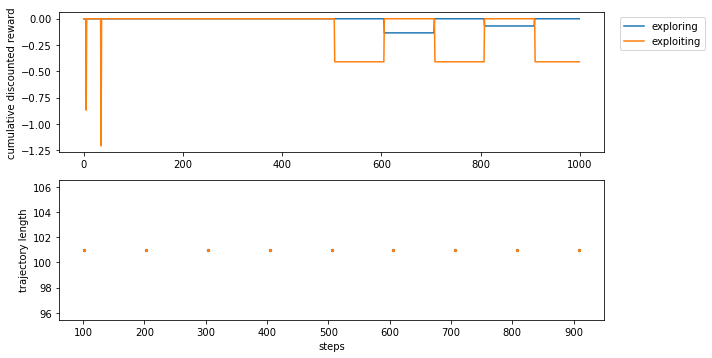

In [24]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,5))
ax1.plot(x, yn, label='exploring')

ax1.plot(x, yg, label='exploiting')

ax1.set_ylabel('cumulative discounted reward')
plt.xlabel('steps')

ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

ax2.set_ylabel('trajectory length')
ax2.scatter(cumEpilen, [ele[0] for ele in epilen], s=5)
ax2.scatter(cumEpilen, [ele[1] for ele in epilen], s=5)
plt.tight_layout()
plt.savefig('results/%s.png' % (FILE_SIG))

In [26]:
from IPython.display import HTML

ani = animate_values(M[0], fn=dict_max)
estimator = ['Qsa', 'Qa']
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=3, metadata=dict(artist='Cesare Carissimo'), bitrate=1800)
# ani.save(f"{FILE_SIG}-%s.mp4" % estimator, writer=writer)
# Show the animation
HTML(ani.to_html5_video())
# HTML(ani.to_jshtml())

## Novelty LambChop

In [129]:
max_steps = 1000
episode_timeout = 100
gamma = 0.8
alpha = 0.1
n_batches = 1

EXPLORATION_TYPE = 'LambQ_Novelty'
WORLD = 'WG'
batch_size = 1
FILE_SIG = f"Results_n={max_steps}, nB={batch_size}, exp={EXPLORATION_TYPE}, WORLD={WORLD}"

if WORLD == 'G2':
    # Create the gridworld, and set cell values to equal rewards
    print('(Creating Willemsen Gridworld)')
    grid = np.ones((3, 9)) * -1
    grid[1,:8] = 0
    grid[1, 8] = 1
    grid[2, :8] = 0
    terminal_state = []
    for i in [0,2]:
        for j in range(8):
            terminal_state.append([i,j])
    terminal_state.append([1,8])
    terminal_state = np.array(terminal_state)
    initial_state = np.array([1, 0])
    blacked_state = np.array([[0, 8],[2, 8]])
elif WORLD == 'G2':
    # Gridworld 2
    grid = np.ones((10, 10)) * 0
    grid[3:7, 3:7] = -1
    grid[9,9] = 1
    terminal_state = np.array([[9,9]])
    initial_state = np.array([1, 0])
    blacked_state = np.array([[5,5], [4,5], [5,4], [4,4]])
    
env = Gridworld(grid, terminal_state, initial_state, blacked_state, episode_timeout)
env_greedy = Gridworld(grid, terminal_state, initial_state, blacked_state, episode_timeout)

In [130]:
M = []
for n in range(n_batches):
    agent = LambChop(estimators = [Estimator(approximator=bellman_N_table(alpha=0.1, gamma=0.8), mask=identity()),
                                  Estimator(approximator=global_N_abstractor(alpha=0.1, gamma=0.8),  mask=global_context())],
                    buffer = ReplayMemory(max_size=10000),
                    targets = [Target()],
                    counter = state_table(),
                    batch_size=batch_size)
    
    trajectories = []
    metrics = []
    epilen = []
    Gn = []
    step = 0
    for step in  tqdm(range(max_steps)):
        # EXPLORE: by setting action selection to be explorative: "exploratory"
        agent.action_selection = "exploratory"
        action = agent.select_action(env.transition)
        transition = env.step(action)
        agent.observe(transition)
        Gn.append(transition.reward)
        agent.train()
        
        # EXPLOIT: by setting action selection to be exploitative: "greedy"
        agent.action_selection = "greedy"
        agent.epsilon = 0
        Gg = []
        
        # RUN entire trajectory, and set greedy env to the initial state
        env_greedy.reset()
        while not env_greedy.terminal and not env_greedy.timeout:
            action = agent.select_action(env_greedy.transition)
            transition = env_greedy.step(action)
            Gg.append(transition.reward)

        step += 1

        metrics.append({
            'Qsa': dict(agent.estimators[0].approximator.table),
            'Qa': dict(agent.estimators[1].evaluate(0)),
            'S': transition.state_,
            'V': dict(agent.counter.table),
            'U': dict(agent.estimators[0].visits),
            'Gn': Gn,
            'Gg': Gg,
            'steps': step
            })
        
        if env.terminal or env.timeout:
            trajectories.append(agent.trajectory)
            epilen.append([len(agent.trajectory), len(Gg)])
            
            env.reset()
            agent.reset_trajectory()
            Gn = []
            
    M.append(metrics)

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\CesareCarissimo\Documents\MARL\RapidRL\MDP\agent.py:103: RuntimeWarning: divide by zero encountered in true_divide
  Zigma = np.where(Sigma > 0, 1 / Sigma, 0.1)  # Zigma is the Inverse of the Sigma MSE matrix


In [131]:
x = np.arange(0, M[0][-1]['steps'])
yn = []
yg = []
for i, metrics in enumerate(M[0]):
    Yn = 0
    Yg = 0
    for j, g in enumerate(metrics['Gn']):
        Yn += gamma**j*g
    for j, g in enumerate(metrics['Gg']):
        Yg += gamma**j*g
    
    yn.append(Yn)
    yg.append(Yg)

In [132]:
cumEpilen = np.cumsum([ele[0] for ele in epilen])
cumEpiG = np.cumsum([ele[1] for ele in epilen])

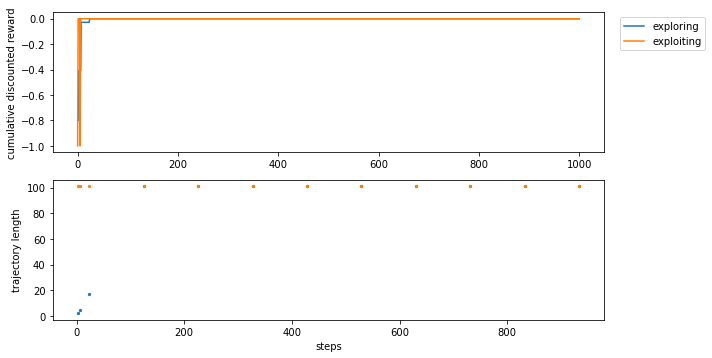

In [133]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,5))
ax1.plot(x, yn, label='exploring')

ax1.plot(x, yg, label='exploiting')

ax1.set_ylabel('cumulative discounted reward')
plt.xlabel('steps')

ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

ax2.set_ylabel('trajectory length')
ax2.scatter(cumEpilen, [ele[0] for ele in epilen], s=5)
ax2.scatter(cumEpilen, [ele[1] for ele in epilen], s=5)
plt.tight_layout()
plt.savefig('results/lambda_Q_global_intrinsic_learner_steps(%i).png' % (max_steps))

In [134]:
ani = animate_values(M[0], fn=dict_max)
estimator = ['Qsa', 'Qa']
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Cesare Carissimo'), bitrate=1800)
ani.save(f"{FILE_SIG}-%s.mp4" % estimator, writer=writer)

## Empirical Bootstrap Code

In [5]:
# percentile based on
# http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html

# adapted according to empirical on
# https://github.com/LizaLebedeva/bootstrap-experiments/blob/master/bootstrap_methods.ipynb

def bootstrap_empirical(data, n=1000, func=np.mean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    obs_metric = func(data) # compute CI center from data directly
#     simulations = simulations - obs_metric # now move bootstrap to differences
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        percentile_upper = simulations[l_indx]
        percentile_lower = simulations[u_indx]
        empirical_lower = 2*obs_metric - percentile_lower
        empirical_upper = 2*obs_metric - percentile_upper
        return(empirical_lower,empirical_upper)
    return(ci)

In [6]:
Rn = np.zeros((n_batches, n_episodes))
Rg = np.zeros((n_batches, n_episodes))

x = []
steps = []

for i, batch in enumerate(M):
    for j, metrics in enumerate(batch):
        for exp, g in enumerate(metrics['Gn']):
            Rn[i,j] += gamma**exp*g
        for exp, g in enumerate(metrics['Gg']):
            Rg[i,j] += gamma**exp*g
    if i == 0:
        x.append(metrics['steps'])
    else:
        x.append(x[i-1]+metrics['steps'])
    steps.append(metrics['steps'])

In [7]:
yn = np.mean(Rn, axis=0)
yg = np.mean(Rg, axis=0)
ynCI = list(map(lambda p: bootstrap_empirical(p)(0.95), Rn.T))
ygCI = list(map(lambda p: bootstrap_empirical(p)(0.95), Rg.T))
Yn = np.transpose(ynCI)
Yg = np.transpose(ygCI)

<IPython.core.display.Javascript object>


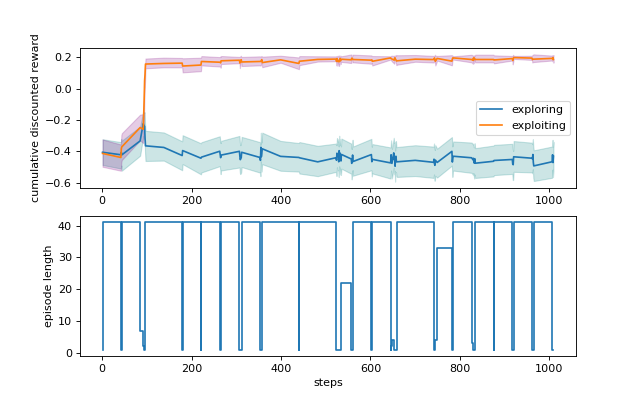

In [10]:
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,5))
ax1.plot(x, yn, label='exploring')
ax1.fill_between(x, Yn[0], Yn[1], color='teal', alpha=.2)

ax1.plot(x, yg, label='exploiting')
ax1.fill_between(x, Yg[0], Yg[1], color='purple', alpha=.2)

ax2.step(x, steps)
# plt.plot([100 for i in range(10)], np.linspace(np.min(Y), np.max(Y), 10), ls='--', color='black', label='greedy threshold')
ax1.set_ylabel('cumulative discounted reward')
ax2.set_ylabel('episode length')
plt.xlabel('steps')

ax1.legend()